In [2]:
import emcee
import matplotlib.pyplot as plt
import pyccl as ccl
import numpy as np
import corner
from IPython.display import display, Math
import seaborn as sns
import matplotlib.colors as mcolors

print(emcee.__version__)

3.1.6


In [69]:
#print(ccl.comoving_radial_distance(cosmo_universe, 1/1.4) - ccl.comoving_radial_distance(cosmo_universe, 1/1.1))
#print(605*np.pi**2/180**2 * ccl.comoving_radial_distance(cosmo_universe, 1/1.55)**2 * (ccl.comoving_radial_distance(cosmo_universe, 1/1.4) - ccl.comoving_radial_distance(cosmo_universe, 1/1.1)) * cosmo_universe["h"]**3)

In [186]:
# Read the HDF5 file (note: no need to reset the backend here)
#filename = "/scratch/c2042999/chains/mcmc_ESS_muSigma_PCACuts_nofsigma8_DEparam.h5"
filename = "mcmc/mcmc_ESS_muSigma_PCACuts_Sigma1_noparam_mild.h5"

while True:
    try:
        reader = emcee.backends.HDFBackend(filename, read_only=True)
        break  # Exit the loop once file is read successfully
    except BlockingIOError:
        # Wait for some time before retrying
        print("File is locked, retrying...")
        time.sleep(0.1)  # Sleep for 1 second before trying again

# Check how many steps have been completed so far
n_steps_completed = reader.iteration
print(f"Number of steps completed: {n_steps_completed}")

# You can also manually access the raw chain and other properties
raw_chain = reader.get_chain(discard=700, thin=20)#discard=800
print(f"Current raw chain shape: {raw_chain.shape}")

tau = reader.get_autocorr_time(tol=0)
max_tau_ratio = np.max(tau * 100 / reader.iteration)
converged = max_tau_ratio < 1
print("Current iteration: {}".format(reader.iteration))
print("Max 100 x Tau/N: {}".format(max_tau_ratio))


Number of steps completed: 18486
Current raw chain shape: (889, 80, 12)
Current iteration: 18486
Max 100 x Tau/N: 0.9963556986283924


In [180]:
# Get the raw chain and log-probabilities
raw_chain = reader.get_chain(flat=False)  # Unflattened chain: (steps, walkers, parameters)
log_prob = reader.get_log_prob(flat=False)  # Unflattened log-probabilities: (steps, walkers)

# Calculate burn-in index
n_burnin = 0

# Remove the burn-in
raw_chain_burnin_removed = raw_chain[n_burnin:]  # Keep steps after burn-in
log_prob_burnin_removed = log_prob[n_burnin:]  # Keep log-probabilities after burn-in

# Flatten the chains after removing burn-in
raw_chain_flat = raw_chain_burnin_removed.reshape(-1, raw_chain.shape[-1])  # (samples, parameters)
log_prob_flat = log_prob_burnin_removed.reshape(-1)  # (samples,)

# Compute the mean of each parameter
mean_params = np.mean(raw_chain_flat, axis=0)

# Find the sample with the maximum log-probability
max_likelihood_index = np.argmax(log_prob_flat)
print("max likelihood value: ", np.max(log_prob_flat))
max_likelihood_params = raw_chain_flat[max_likelihood_index]

# Print the results
print("Mean parameter values (after burn-in):")
print(mean_params)

print("Maximum likelihood parameter values (after burn-in):")
print(max_likelihood_params)
print("Maximum likelihood: ", log_prob_flat[max_likelihood_index])


max likelihood value:  8.689597146693282
Mean parameter values (after burn-in):
[ 0.27483415  0.43070573 -0.00632927  2.06381337  0.66895884  0.9627946
  0.02238766  1.57893587  1.74070178  1.91405943  2.09661498  2.28593407]
Maximum likelihood parameter values (after burn-in):
[ 0.27483188  0.42250574 -0.0104898   2.06484898  0.66962752  0.96124494
  0.02236755  1.57524742  1.73524397  1.90786897  2.08719499  2.27674682]
Maximum likelihood:  8.689597146693282


In [184]:
"""Get the GR only version"""
#filename = "/scratch/c2042999/chains/mcmc_ESS_muSigma_PCACuts_GRonly.h5"
#filename = "mcmc/mcmc_ESS_muSigma_PCACuts_Sigma1_nofsigma8_noparam.h5"
filename = "mcmc/mcmc_ESS_muSigma_PCACuts_Sigma1_mild.h5"


while True:
    try:
        reader = emcee.backends.HDFBackend(filename, read_only=True)
        break  # Exit the loop once file is read successfully
    except BlockingIOError:
        # Wait for some time before retrying
        print("File is locked, retrying...")
        time.sleep(0.1)  # Sleep for 1 second before trying again

raw_chain_PCAGRonlycuts = reader.get_chain(discard=300)#discard=400, thin=20

# Check how many steps have been completed so far
n_steps_completed = reader.iteration
print(f"Number of steps completed: {n_steps_completed}")

# You can also manually access the raw chain and other properties
print(f"Current raw chain shape: {raw_chain_PCAGRonlycuts.shape}")


tau = reader.get_autocorr_time(tol=0)
max_tau_ratio = np.max(tau * 100 / reader.iteration)
converged = max_tau_ratio < 1
print("Current iteration: {}".format(reader.iteration))
print("Max 100 x Tau/N: {}".format(max_tau_ratio))


Number of steps completed: 4556
Current raw chain shape: (4256, 80, 12)
Current iteration: 4556
Max 100 x Tau/N: 2.8878646994775954


In [125]:
# Define cosmology

cosmo_universe = ccl.Cosmology(Omega_c = 0.269619, 
                          Omega_b = 0.050041,
                          h = 0.6688,
                          n_s = 0.9626,
                          A_s = 2.092e-9)

Bias_distribution_fiducial = np.array([1.562362,
                             1.732963,
                             1.913252,
                             2.100644,
                             2.293210])

In [127]:
labels = [r"$\Omega_c$", r"$\mu_0$",r"$\Sigma_0$", r"$10^{9}A_s$", r"$h$", r"$n_s$", r"$\omega_b$",\
         r'$b_1$', r'$b_2$', r'$b_3$', r'$b_4$', r'$b_5$']

value1 = [cosmo_universe["Omega_c"], 0.0,0.0, cosmo_universe["A_s"]*1e9, cosmo_universe["h"],\
          cosmo_universe["n_s"],cosmo_universe["Omega_b"]*cosmo_universe["h"]**2,\
         Bias_distribution_fiducial[0], Bias_distribution_fiducial[1],\
         Bias_distribution_fiducial[2],Bias_distribution_fiducial[3],\
         Bias_distribution_fiducial[4]]

lower_value1 = [0.28 - 0.06, -1.5,-1.5,  1.7, 0.61 , 0.92, 0.04, 0.8,0.8,0.8,0.8,0.8]
upper_value1 = [0.36 - 0.04, 1.5,1.5,  2.5, 0.73,1 , 0.06, 3.0,3.0,3.0,3.0,3.0]



In [202]:
# Assuming `raw_chain` is the MCMC chain you have loaded from the file.
filename = "mcmc/mcmc_ESS_muSigma_StandardCuts_Sigma1_noparam_mild.h5"

while True:
    try:
        reader = emcee.backends.HDFBackend(filename, read_only=True)
        break  # Exit the loop once file is read successfully
    except BlockingIOError:
        # Wait for some time before retrying
        print("File is locked, retrying...")
        time.sleep(0.1)  # Sleep for 1 second before trying again

raw_chain_standardcuts = reader.get_chain(discard=300)#

# Check how many steps have been completed so far
n_steps_completed = reader.iteration
print(f"Number of steps completed: {n_steps_completed}")

# You can also manually access the raw chain and other properties
print(f"Current raw chain shape: {raw_chain_standardcuts.shape}")


tau = reader.get_autocorr_time(tol=0)
max_tau_ratio = np.max(tau * 100 / reader.iteration)
converged = max_tau_ratio < 1
print("Current iteration: {}".format(reader.iteration))
print("Max 100 x Tau/N: {}".format(max_tau_ratio))


Number of steps completed: 25900
Current raw chain shape: (25600, 80, 12)
Current iteration: 25900
Max 100 x Tau/N: 0.9995378291667056


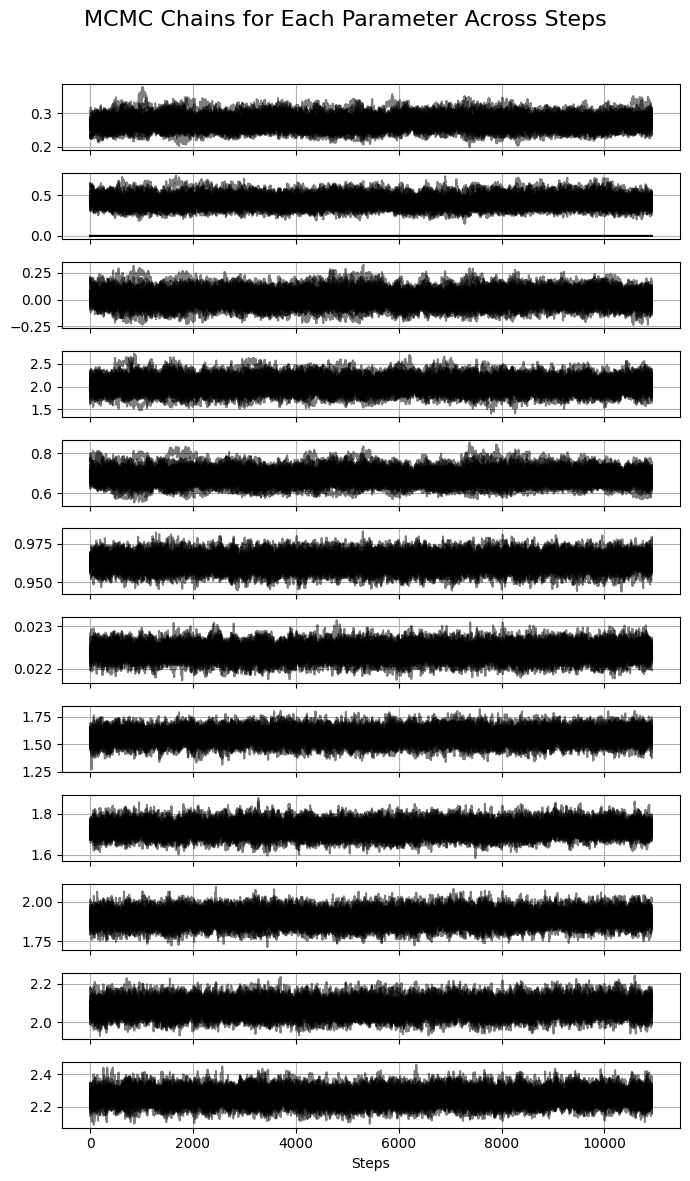

In [197]:
# Assuming `raw_chain` is the MCMC chain you have loaded from the file.
n_steps, n_walkers, n_params = raw_chain.shape

# Create a figure with subplots, one for each parameter
fig, axes = plt.subplots(n_params, figsize=(7, n_params), sharex=True)

# Iterate over each parameter and plot its evolution
for i in range(n_params):
    ax = axes[i]
    for j in range(40):
        ax.plot(raw_chain_standardcuts[:, j, i], alpha=0.5, color="k")  # Plot for each walker
        #ax.plot(raw_chain[:, j, i], alpha=0.5, color="r")  # Plot for each walker
        #ax.plot(raw_chain_PCAGRonlycuts[:, j, i], alpha=0.5, color="g")  # Plot for each walker
    ax.plot(np.arange(len(raw_chain_standardcuts[:, 0, 0])), value1[i]*np.ones(len(raw_chain_standardcuts[:, 0, 0])), color="k")

    """
    ax.plot(np.arange(len(raw_chain_standardcuts[:, 0, 0])), value1[i]*np.ones(len(raw_chain_standardcuts[:, 0, 0])), color="g")
    ax.plot(np.arange(len(raw_chain_standardcuts[:, 0, 0])), lower_value1[i]*np.ones(len(raw_chain_standardcuts[:, 0, 0])), color="g", linestyle="--")
    ax.plot(np.arange(len(raw_chain_standardcuts[:, 0, 0])), upper_value1[i]*np.ones(len(raw_chain_standardcuts[:, 0, 0])), color="g", linestyle="--")
    """
    #ax.set_ylabel(labels[i])
    ax.grid()

# Add a label for the shared x-axis (steps/iterations)
axes[-1].set_xlabel("Steps")

# Set the overall title and adjust layout
plt.suptitle("MCMC Chains for Each Parameter Across Steps", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
#plt.savefig("chains_ESS_noparametrization.pdf", bbox_inches='tight')
plt.show()

In [93]:
for i in range(11):
    mcmc = np.percentile(raw_chain[:, :, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [94]:
for i in range(11):
    mcmc = np.percentile(raw_chain_standardcuts[:, :, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [22]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.serif": ["CMU Serif", "DejaVu Serif"]
})
col = sns.color_palette("colorblind") 

In [23]:
print(col[0])  # Should output something like (r, g, b) or (r, g, b, a)

(0.00392156862745098, 0.45098039215686275, 0.6980392156862745)


(874000, 5)
(71120, 5)
(340480, 5)


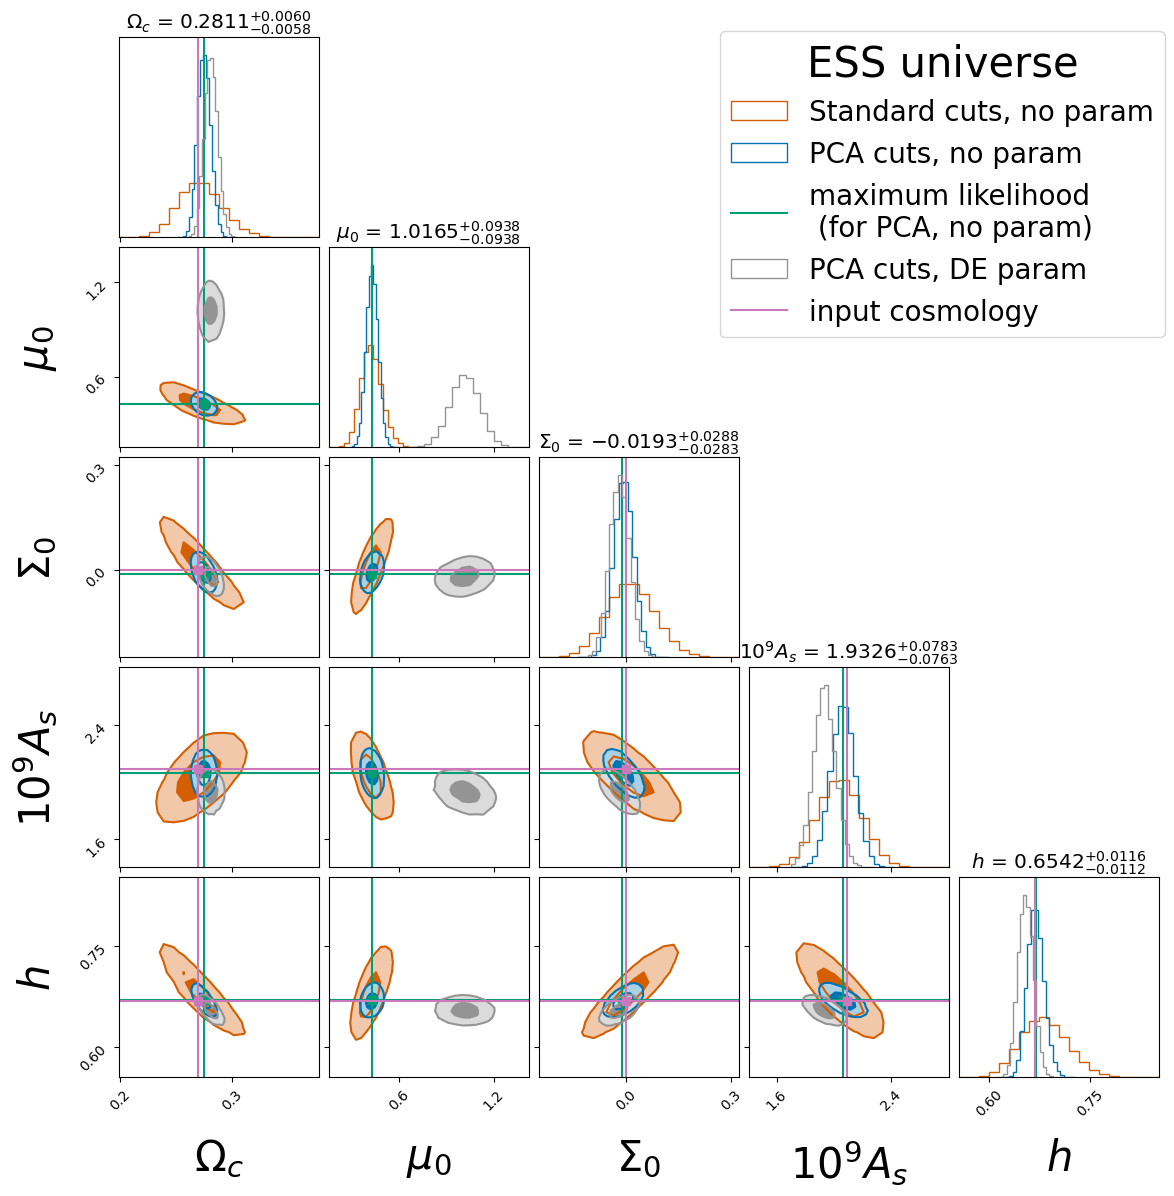

In [201]:
#### STANDARD CUTS #####

ndim = 5#len(labels)
burned_chain = raw_chain_standardcuts


CORNER_KWARGS = dict(
    label_kwargs=dict(fontsize=30),
    title_kwargs=dict(fontsize=14.5),
    show_titles=True,
    smooth = False,
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2)),
    plot_datapoints=False,
    fill_contours=True,
    max_n_ticks=2,
    title_fmt=".4f"
)

flat_samples =  burned_chain.reshape(-1, n_params)[:,:ndim]

print(flat_samples.shape)
len_chain_standardcuts = flat_samples.shape[0]

figure = corner.corner(
    flat_samples, **CORNER_KWARGS, labels=labels, color = mcolors.to_hex(col[3]),hist_kwargs=dict(density=True)
);


### PCA CUTS####

burned_chain = raw_chain
flat_samples =  burned_chain.reshape(-1, n_params)[:,:ndim]

CORNER_KWARGS = dict(
    label_kwargs=dict(fontsize=30),
    title_kwargs=dict(fontsize=14.5),
    show_titles=True,
    smooth = False,
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2)), #, 1-np.exp(-s**2/2)
    plot_datapoints=False,
    fill_contours=True,
    max_n_ticks=2,
    title_fmt=".4f",
    truths=max_likelihood_params[:ndim],
    truth_color=mcolors.to_rgba(col[2], alpha=1.0)
)

print(flat_samples.shape)

corner.corner(
    flat_samples, fig=figure, **CORNER_KWARGS, labels=labels, color=mcolors.to_hex(col[0]),hist_kwargs=dict(density=True)
);


## Add PCA only with fsigma8
CORNER_KWARGS = dict(
    label_kwargs=dict(fontsize=30),
    title_kwargs=dict(fontsize=14.5),
    show_titles=True,
    smooth = False,
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2)),
    plot_datapoints=False,
    fill_contours=True,
    max_n_ticks=2,
    title_fmt=".4f",
    truths=value1[:ndim],
    truth_color=mcolors.to_hex(col[4])
)

burnin = 0
burned_chain = raw_chain_PCAGRonlycuts[burnin:, :, :]
flat_samples =  burned_chain.reshape(-1, n_params)[:,:ndim]

print(flat_samples.shape)

corner.corner(
    flat_samples, fig=figure, **CORNER_KWARGS, labels=labels, color=mcolors.to_hex(col[7]),hist_kwargs=dict(density=True)
);

######################
# Extract the axes
#axes = np.array(figure.axes).reshape((ndim, ndim))
"""
# Loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(value1[i], color="g")
    #ax.axvline(mean_params[i], color="r")
    ax.axvline(max_likelihood_params[i], color="b")

ax.axvline(max_likelihood_params[ndim-1], color="b")


# Loop over histograms
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(value1[xi], color="g")
        ax.axhline(value1[yi], color="g")
"""

"""
# Plot prior on mu/Sigma for numerical instability
mu_0_array_plot = np.linspace(-1,4,10)
axes[2, 1].fill_between(mu_0_array_plot,(mu_0_array_plot - 1)/2,   min((mu_0_array_plot - 1)/2), hatch="//", facecolor="g", alpha=.5)
#mu0 <= 2*Sigma0 + 1.0 
"""
#plt.legend(["3x2pt, Existing method (linear scale cuts)","maximum likelihood \n (for PCA-based cuts)","3x2pt, Our method (PCA-based cuts)","input cosmology"],\
#           bbox_to_anchor=(1.0, 12.7), fontsize=40,title=r"ESS universe",title_fontsize=60)
#plt.legend(["Existing method, 3x2pt","maximum likelihood \n (for PCA-based cuts)","PCA method, 3x2pt","input cosmology"], bbox_to_anchor=(1.1, 5.3), fontsize=20,title=r"ESS universe",title_fontsize=30)
plt.legend(["Standard cuts, no param","PCA cuts, no param","maximum likelihood \n (for PCA, no param)","PCA cuts, DE param","input cosmology"], bbox_to_anchor=(1.1, 5.3), fontsize=20,title=r"ESS universe",title_fontsize=30)

#plt.savefig("/home/c2042999/PCA_project/Figures/Final_figures/3x2pt_ESS_mild.pdf", bbox_inches='tight')


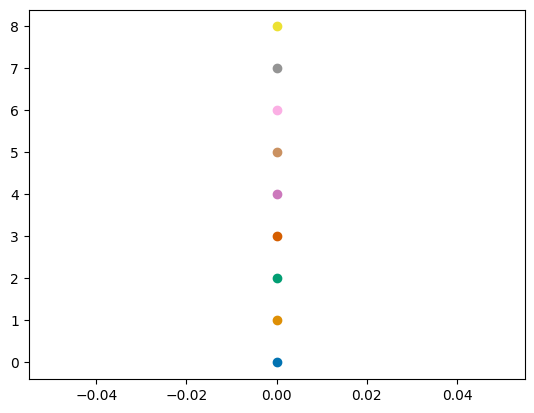

In [379]:
for i in range(9):
    plt.scatter(0,i,color=mcolors.to_hex(col[i]))


## WAIC criterion

In [43]:
import h5py

In [46]:
# Load the MCMC samples and log-likelihoods
def load_mcmc_data(filename):
    with h5py.File(filename, 'r') as f:
        samples = f['mcmc']['chain'][...]      # shape: (n_walkers, n_steps, n_params)
        log_likelihood = f['mcmc']['log_prob'][...]  # shape: (n_walkers, n_steps)
    return samples, log_likelihood

# Files for both models
file_model_1 = '/scratch/c2042999/chains/mcmc_ESS_muSigma_PCACuts_noparam.h5'
file_model_2 = '/scratch/c2042999/chains/mcmc_ESS_muSigma_StandardCuts_noparam.h5'

samples_1, log_likelihood_1 = load_mcmc_data(file_model_1)
samples_2, log_likelihood_2 = load_mcmc_data(file_model_2)

In [47]:
def compute_waic(log_likelihood):
    # Reshape to (n_samples, n_data) if needed
    log_likelihood = log_likelihood.reshape(-1, log_likelihood.shape[-1])

    # Log Pointwise Predictive Density (lppd)
    lppd = np.sum(np.log(np.mean(np.exp(log_likelihood), axis=0)))

    # Effective number of parameters (p_WAIC)
    p_waic = np.sum(np.var(log_likelihood, axis=0))

    # WAIC Calculation
    waic = -2 * (lppd - p_waic)
    return waic

# WAIC for both models
waic_model_1 = compute_waic(log_likelihood_1)
waic_model_2 = compute_waic(log_likelihood_2)

# Display the results
print(f"WAIC for Model 1 (PCA Cuts): {waic_model_1}")
print(f"WAIC for Model 2 (Standard Cuts): {waic_model_2}")

WAIC for Model 1 (PCA Cuts): 14892.2541258095
WAIC for Model 2 (Standard Cuts): 4487.198990053972


In [48]:
def waic_se(log_likelihood):
    log_likelihood = log_likelihood.reshape(-1, log_likelihood.shape[-1])
    return np.sqrt(len(log_likelihood[0]) * np.var(np.var(log_likelihood, axis=0)))

se_model_1 = waic_se(log_likelihood_1)
se_model_2 = waic_se(log_likelihood_2)

delta_waic = waic_model_1 - waic_model_2
se_delta = np.sqrt(se_model_1**2 + se_model_2**2)

print(f"ΔWAIC = {delta_waic} ± {se_delta}")

ΔWAIC = 10405.055135755529 ± 406.0781495587649
